<a href="https://colab.research.google.com/github/wayne-chi/Cassava_disease_detection_using_ensemble_models/blob/main/resnet50_pure_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
name_output = input('enter the name of your output file ').strip()

enter the name of your output file resnet50november3


# Import Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision,TruePositives,TrueNegatives, FalsePositives,FalseNegatives,Accuracy

In [ ]:
import os
import shutil
import glob
import random
import warnings
warnings.simplefilter(action='ignore',category='FutureWarning')

# Add GPU

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) >=1:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  1


# Make your edits

In [ ]:
this_model_name = name_output+'.h5'

In [ ]:
model_name='Mobilenet_2'

In [ ]:
image_zip = 'All_cassava_data.zip'   #'More_Cassava.zip'#'clean_annotated_cassava.zip'

In [ ]:
## chnage home directory
home = '/content/drive/MyDrive/project/Project2.1/Script2_pure classification' #'/content/drive/MyDrive/project/Tensorflow And Keras' #

# Pull Data and Setup

In [ ]:


image_path = model_name + '_data'
os.mkdir(image_path)

shutil.copy(os.path.join(home,'Images',image_zip),image_zip)

'All_cassava_data.zip'

In [ ]:
shutil.unpack_archive(image_zip,os.getcwd(),'zip')

In [ ]:
folders = os.listdir(image_zip[:-4])
folders

['brownstreak_N', 'greenmite_N', 'blight_N', 'Mosaic_N']

### Edit here or type name of folder

In [ ]:
f_folders = list(filter(lambda x:  x.endswith('N') , folders) )
f_folders = sorted(f_folders)
f_folders

['Mosaic_N', 'blight_N', 'brownstreak_N', 'greenmite_N']

## Create path and arrange

In [ ]:
os.mkdir(os.path.join(image_path,'train'))
os.mkdir(os.path.join(image_path,'test'))
os.mkdir(os.path.join(image_path,'valid'))

In [ ]:
for fold in f_folders:
  src = os.path.join(image_zip[:-4],fold)
  dest = os.path.join(image_path,'train')
  shutil.move(src,dest)

  c_test_dis = os.path.join(image_path,'test',fold)
  c_valid_dis = os.path.join(image_path,'valid',fold)
  os.mkdir(c_test_dis)
  os.mkdir(c_valid_dis)

## delete xml files
  total_files = os.listdir(os.path.join(dest,fold))
  to_del = filter(lambda x: x.endswith('xml'),total_files)
  for i in to_del:
    os.remove(os.path.join(dest,fold,i))

## pick out a few and move to valid
  valid_amount = 2 * len(os.listdir(os.path.join(dest,fold)))  //10
  test_amount = len(os.listdir(os.path.join(dest,fold))) //10

  valid_samples = random.sample(os.listdir(os.path.join(dest,fold)), valid_amount)
  for f in valid_samples:
        shutil.move(os.path.join(dest,fold,f), c_valid_dis)

## pick out a few and move to test
  test_samples = random.sample(os.listdir(os.path.join(dest,fold)), test_amount)
  for k in test_samples:
        shutil.move(os.path.join(dest,fold,k), c_test_dis)

# The Plot Functions

## Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  this function prints and plots the confusion matrix
  normalization can be applied by setting normalize=True
  """
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tickmarks=  np.arange(len(classes))
  plt.xticks(tickmarks,classes,rotation=45)
  plt.yticks(tickmarks,classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1) [:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('confusion matrix without normalization')

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(i,j,cm[i,j],
             horizontalalignment='center',
             color = 'white' if cm[i,j] > thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

# Instantiate the model

In [ ]:
Home_model = tf.keras.applications.resnet50.ResNet50(include_top = False,
                                                     input_shape=(224, 224, 3),
                                                     pooling = 'avg',
                                                     classes=4,
                                                     weights='imagenet'
                                                     )

94765736/94765736 [==============================] - 0s 0us/step


## Preprocess

In [ ]:
def prepare_image(file):
  img = image.load_img(file, target_size = (224,224))
  img_array = image.img_to_array(img)
  # print(img_array.shape)
  img_array_expanded = np.expand_dims(img_array,axis=0)
  # print(img_array_expanded.shape)
  return tf.keras.applications.resnet50.preprocess_input(img_array_expanded)

## Transfer Learning

In [ ]:
train_path = os.path.join(image_path,'train')
valid_path = os.path.join(image_path,'valid')
test_path = os.path.join(image_path,'test')

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
              .flow_from_directory(directory= train_path,target_size=(224,224),batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
              .flow_from_directory(directory= valid_path,target_size=(224,224),batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
              .flow_from_directory(directory= test_path,target_size=(224,224),batch_size=10, shuffle = False)


Found 1213 images belonging to 4 classes.
Found 343 images belonging to 4 classes.
Found 170 images belonging to 4 classes.


In [ ]:
Home_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
len(Home_model.layers)

176

In [ ]:
for layer in Home_model.layers:
  layer.trainable=False

In [ ]:
resnet_model = Sequential()

In [ ]:
resnet_model.add(InputLayer(input_shape=(224,224,3 ), name='Input_Layer'))

In [ ]:
resnet_model.add(Home_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4,activation='softmax'))


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


# Train The Model

In [ ]:
resnet_model.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',Recall(), Precision(),TruePositives(),TrueNegatives(), FalsePositives(),FalseNegatives()]
)

In [ ]:
epochs=  20

In [ ]:
History = resnet_model.fit(
    x = train_batches,
    validation_data = valid_batches,
    epochs = epochs,
    verbose=2
    )

Epoch 1/20
122/122 - 28s - loss: 0.6855 - accuracy: 0.7420 - recall: 0.6653 - precision: 0.7873 - true_positives: 807.0000 - true_negatives: 3421.0000 - false_positives: 218.0000 - false_negatives: 406.0000 - val_loss: 0.5059 - val_accuracy: 0.8192 - val_recall: 0.7784 - val_precision: 0.8449 - val_true_positives: 267.0000 - val_true_negatives: 980.0000 - val_false_positives: 49.0000 - val_false_negatives: 76.0000 - 28s/epoch - 232ms/step
Epoch 2/20
122/122 - 14s - loss: 0.3409 - accuracy: 0.8788 - recall: 0.8533 - precision: 0.9024 - true_positives: 1035.0000 - true_negatives: 3527.0000 - false_positives: 112.0000 - false_negatives: 178.0000 - val_loss: 0.4358 - val_accuracy: 0.8338 - val_recall: 0.8163 - val_precision: 0.8615 - val_true_positives: 280.0000 - val_true_negatives: 984.0000 - val_false_positives: 45.0000 - val_false_negatives: 63.0000 - 14s/epoch - 117ms/step
Epoch 3/20
122/122 - 15s - loss: 0.2424 - accuracy: 0.9167 - recall: 0.8986 - precision: 0.9380 - true_positives:

In [ ]:
History.history

{'loss': [0.685525119304657,
  0.3409257233142853,
  0.24238218367099762,
  0.18470323085784912,
  0.1523035764694214,
  0.1291119009256363,
  0.10195805877447128,
  0.08348851650953293,
  0.06978866457939148,
  0.057164642959833145,
  0.050843704491853714,
  0.04186354577541351,
  0.03820240870118141,
  0.03165857493877411,
  0.02708190679550171,
  0.02360996976494789,
  0.021124711260199547,
  0.02083444595336914,
  0.019468851387500763,
  0.014208772219717503],
 'accuracy': [0.7419620752334595,
  0.878812849521637,
  0.9167353510856628,
  0.944765031337738,
  0.9579554796218872,
  0.9670239090919495,
  0.978565514087677,
  0.9810387492179871,
  0.9868095517158508,
  0.9925803542137146,
  0.9925803542137146,
  0.9967023730278015,
  0.9950535893440247,
  0.9983512163162231,
  0.9983512163162231,
  0.9983512163162231,
  0.9991756081581116,
  0.9983512163162231,
  0.9983512163162231,
  0.9991756081581116],
 'recall': [0.6652926802635193,
  0.8532564043998718,
  0.8985984921455383,
  0.9

In [ ]:
import pandas as pd

In [ ]:
history_df = pd.DataFrame(History.history)

In [ ]:
history_df.to_csv(os.path.join(home,'output',name_output+'.csv'))

# Predict

In [ ]:
test_labels= test_batches.classes

In [ ]:
x_test =  np.concatenate([test_batches.next()[0] for i in range(test_batches.__len__())])

In [ ]:
predictions = resnet_model.predict(  x = x_test,verbose=0)

In [ ]:
dff = pd.DataFrame(predictions)

In [ ]:
dff['test'] = test_labels
dff.head(10)

,0,1,2,3,test
0,0.001412,0.000113,0.107643,0.890832,0
1,0.995122,0.000053,0.004445,0.000381,0
2,0.974491,0.000088,0.024816,0.000605,0
3,0.998717,0.000057,0.000977,0.000249,0
4,0.994699,0.000017,0.002090,0.003194,0
5,0.997530,0.000656,0.001705,0.000109,0
6,0.971552,0.025474,0.002557,0.000417,0
7,0.997682,0.001182,0.000376,0.000760,0
8,0.000006,0.153965,0.845383,0.000646,1
9,0.011075,0.231415,0.595731,0.161779,1


### Take prediction Probability to csv

In [ ]:
dff.to_csv(os.path.join(home,'output',name_output+'_prediction_probabilities.csv'))

## Confusion matrix

In [ ]:
cm = confusion_matrix(y_pred = np.argmax(predictions,axis=-1),y_true=test_labels)

In [ ]:
test_batches.class_indices

{'Mosaic_N': 0, 'blight_N': 1, 'brownstreak_N': 2, 'greenmite_N': 3}

In [ ]:
cm_plot_labels = [i for i in test_batches.class_indices.keys()]

confusion matrix without normalization


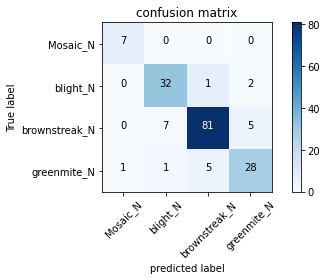

In [ ]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title = 'confusion matrix')

# Save Model

In [ ]:
resnet_model.save(this_model_name)

In [ ]:
model_path = os.path.join(home,'models')
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [ ]:
shutil.move(this_model_name,model_path)

'/content/drive/MyDrive/project/Project2.1/Script2_pure classification/models/resnet50november3.h5'